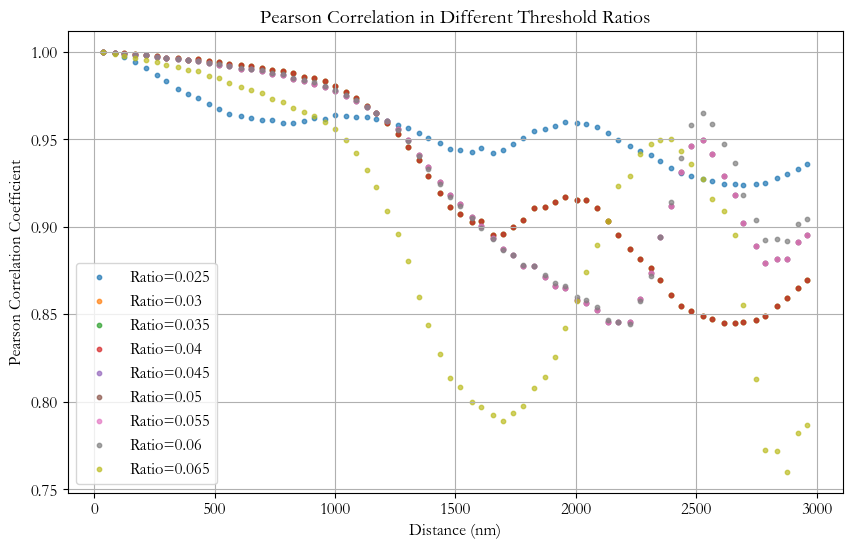

In [77]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 28 22:42:27 2025

@author: yanjie
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fft import fft2, fftshift
from scipy.stats import pearsonr

# 定义要测试的不同阈值比例
threshold_ratios = [0.025,0.03,0.035,0.04,0.045,0.05,0.055,0.06,0.065]  # 示例阈值列表

# Directory and filenames
base_path = r"D:\bead image\Beadimages\Beadimage1"
files = [
    f for f in os.listdir(base_path)
    if f.startswith("Moving") and f.endswith(".png")
]

# Function to extract distance, handles potential errors, and returns filename and distance
def extract_distance_and_filename(fname):
    match = re.search(r'-(\d+)nm', fname)
    if match:
        distance = int(match.group(1))
        return fname, distance
    else:
        return fname, None  # Return None for distance if not found

# Sort files based on extracted distance
files_with_distances = [extract_distance_and_filename(f) for f in files]
files_with_distances = [
    (fname, distance) for fname, distance in files_with_distances if distance is not None
]  # Filter out files where distance wasn't found.
files_with_distances.sort(key=lambda x: x[1])  # Sort by distance
sorted_files = [fname for fname, _ in files_with_distances]  # extract sorted filenames

#%%
# Specify reference filename
ref_filename = "MovingBead-0_-35nm.png"

# Get the index of the reference image
try:
    ref_index = sorted_files.index(ref_filename)
except ValueError:
    raise ValueError(f"{ref_filename} not found in file list.")

# Define window size
window_size = 5

# Safely get the subset of files
start_index = max(ref_index - window_size, 0)
end_index = min(ref_index + window_size + 1, len(sorted_files))
selected_files = sorted_files[start_index:end_index]


#%%
# Reference image
ref_img = Image.open(os.path.join(base_path, ref_filename)).convert("L")

# Determine minimum common shape across all images
shapes = [Image.open(os.path.join(base_path, f)).convert("L").size[::-1] for f in sorted_files]
min_shape = (min(s[0] for s in shapes), min(s[1] for s in shapes))

# Crop and FFT the reference image
ref_img_cropped = np.array(ref_img)[:min_shape[0], :min_shape[1]]
ref_fft = fftshift(fft2(ref_img_cropped))

# High-pass filter function
def high_pass_filter(img_fft, threshold_ratio):
    h, w = img_fft.shape
    cx, cy = w // 2, h // 2
    radius = min(cx, cy) * threshold_ratio
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    mask = dist_from_center >= radius
    return img_fft * mask

# Extract distance from filename
def extract_distance(fname):
    match = re.search(r'-(\d+)nm', fname)
    return int(match.group(1)) if match else None


def compute_radial_profile(image_fft):
    h, w = image_fft.shape
    y, x = np.indices((h, w))
    center = (int(h / 2), int(w / 2))
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(np.int32)
    radial_mean = np.bincount(r.ravel(), image_fft.ravel()) / np.bincount(r.ravel())
    return radial_mean

use_radial_profile = True # Set to False to use 2D FFT correlation instead

# Compute correlation coefficients
results = []
for threshold_ratio in threshold_ratios:
    # 每次循环重新生成参考图像滤波结果
    ref_fft_filtered = high_pass_filter(ref_fft, threshold_ratio)  # 添加这行
    
    for fname in files:
        img = Image.open(os.path.join(base_path, fname)).convert("L")
        img_cropped = np.array(img)[:min_shape[0], :min_shape[1]]
        img_fft = fftshift(fft2(img_cropped))
        img_fft_filtered = high_pass_filter(img_fft, threshold_ratio)
        if use_radial_profile:
            ref_profile = compute_radial_profile(np.abs(ref_fft_filtered)**1)
            img_profile = compute_radial_profile(np.abs(img_fft_filtered)**1)
            min_len = min(len(ref_profile), len(img_profile))
            r_value, _ = pearsonr(ref_profile[:min_len], img_profile[:min_len])
        else:
            r_value, _ = pearsonr(np.abs(ref_fft_filtered.flatten()), np.abs(img_fft_filtered.flatten()))
    #        r_value, _ = pearsonr(ref_fft_filtered.flatten().real, img_fft_filtered.flatten().real)

        distance = extract_distance(fname)
        if distance is not None:
            results.append((threshold_ratio, distance, r_value))

"""
# Compute correlation coefficients
results = []
for fname in files:
#for fname in selected_files:
    img = Image.open(os.path.join(base_path, fname)).convert("L")
    img_cropped = np.array(img)[:min_shape[0], :min_shape[1]]
    img_fft = fftshift(fft2(img_cropped))
    img_fft_filtered = high_pass_filter(img_fft)

    # Flatten and compute Pearson correlation
#    r_value, _ = pearsonr(ref_fft_filtered.flatten().real, img_fft_filtered.flatten().real)
    r_value, _ = pearsonr(np.abs(ref_fft_filtered.flatten()), np.abs(img_fft_filtered.flatten()))
    distance = extract_distance(fname)
    if distance is not None:
        results.append((distance, r_value))
"""

# Sort and save results
results.sort(key=lambda x: (x[0], x[1]))  # Sort by distance, then by correlation
# 转换结果到DataFrame
df_results = pd.DataFrame(results, columns=["Threshold Ratio", "Distance (nm)", "Pearson r"])

# Polynomial fit
distances = df_results["Distance (nm)"].values
correlations = df_results["Pearson r"].values
# You can adjust the degree of the polynomial (e.g., 3 for cubic, 4 for quartic)
degree = 3
coeffs = np.polyfit(distances, correlations, degree)
polynomial_fit = np.poly1d(coeffs)
fitted_correlations = polynomial_fit(distances) #get the fitted y values

# Plot
# 绘制不同阈值的散点图
plt.figure(figsize=(10, 6))
for i, ratio in enumerate(threshold_ratios):
    mask = df_results["Threshold Ratio"] == ratio
    plt.scatter(df_results[mask]["Distance (nm)"], 
                df_results[mask]["Pearson r"], 
                label=f'Ratio={ratio}',
                s=10,
                alpha=0.7)

plt.xlabel('Distance (nm)')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Pearson Correlation in Different Threshold Ratios')
plt.legend()
plt.grid(True)
plt.show()


Text(0, 0.5, 'Pearson r')

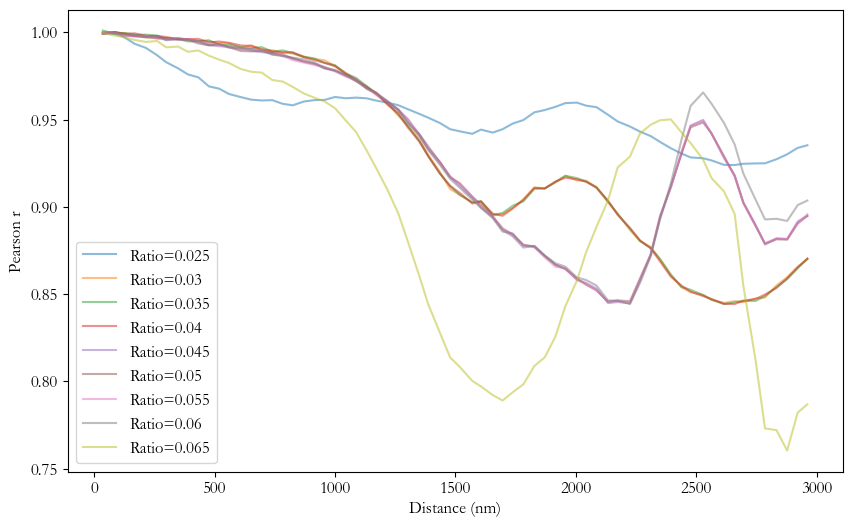

In [79]:
plt.figure(figsize=(10,6))
for ratio in threshold_ratios:
    mask = df_results["Threshold Ratio"] == ratio
    x = df_results[mask]["Distance (nm)"]
    y = df_results[mask]["Pearson r"] + np.random.uniform(-0.001, 0.001, len(x)) # 添加y轴抖动
    plt.plot(x, y, alpha=0.5, label=f'Ratio={ratio}')
plt.legend()
plt.xlabel("Distance (nm)")
plt.ylabel("Pearson r")

Text(0.5, 0, 'Pearson r')

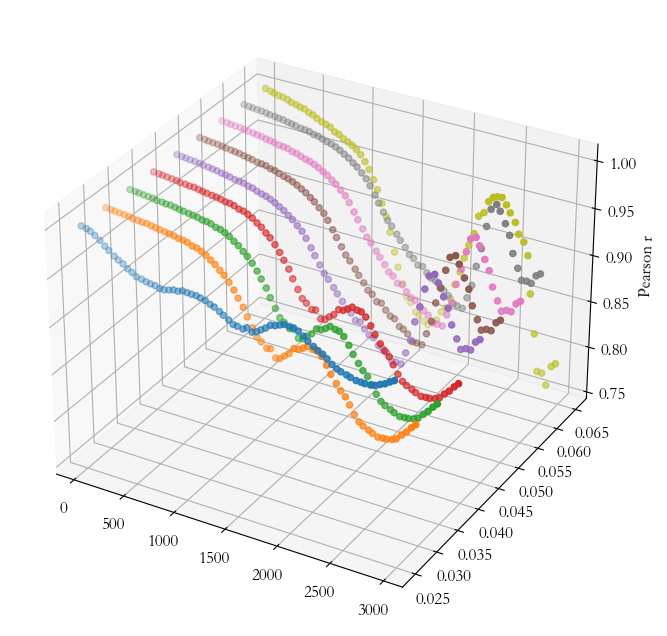

In [74]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for ratio in threshold_ratios:
    mask = df_results["Threshold Ratio"] == ratio
    ax.scatter(df_results[mask]["Distance (nm)"], 
               df_results[mask]["Threshold Ratio"],
               df_results[mask]["Pearson r"],
               label=f'Ratio={ratio}')
ax.set_zlabel('Pearson r')